In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix as csr
from scipy.sparse import lil_matrix as lil
from scipy.sparse import kron
from scipy.sparse.linalg import eigs, eigsh
import timeit
import scipy.sparse as sps
from numpy import linalg as LA

In [2]:
def Lanczos(OL,OR,n_eigvals,max_iter,init_vec):
    
    #Function for diagonalizing superblock Hamiltonian of our systems
    #using Left block & Right block Operators without calculating their kron product

    num_terms = len(OL) #number of terms in superblock Hamiltonian

    Dim_L = np.size(OL[0], axis = 1) #left operators dimension
    Dim_R = np.size(OR[0], axis = 1) #right operators dimension

    Dim_tot = Dim_L*Dim_R #superblock Hamiltonian dimension
    
    v_prev = init_vec.ravel()#v1
    
    vec = np.zeros((max_iter+3,Dim_tot)) #storing the vectors in Krylov space
    vec[1,:] = v_prev
    
    beta = np.zeros(max_iter+3)
    alpha = np.zeros(max_iter+3)
    
    D0 = np.zeros(n_eigvals) # storing eigenvalues at each iteration and checking convergence
    j_min = 2*n_eigvals + 2  # minimun number of iterations 
    tol = 10**(-12) # if the difference between eigenvalues in current and previous iteration is less than tol
    #then we have reached convergence and we can break the loop
    
    #Main loop:
    for j in range(1,max_iter+2):
        
        v_first = vec[j-1,:] #v_0
        v_prev = vec[j,:] #v_1
        # here we don't have the superblock Hamiltonian matrix, instead we have the left & right operators 
        # that by calculating their kron product we can get the superblock Hamiltonian matrix
        # but we don't want to use kron product because it's not efficient
        # instead we reshape v_prev into Dim_L & Dim_R, then take the i-th
        # component of O_L and O_R lists, and multiply O_L{i} from the left and
        # transpose of O_R{i} from the right and then take sum over i's.
        # This yields the reshape of v_next (as a matrix) 
        # by an additional reshape we can change its dimension to be a vector
        
        v_prev = np.reshape(v_prev,(Dim_L,Dim_R))
        
        #new vector:
        v_next = 0
        for i in range(num_terms):
            v_next = v_next + OL[i]*v_prev*np.transpose(OR[i])
        #v_2 = OL[1]*v_1*OR'[1] + OL[2]*v_1*OR'[2] + OL[3]*v_1*OR'[3] + ...

        v_prev = np.reshape(v_prev,(1,-1))   #reshape to be a vector
        v_next = np.reshape(v_next,(1,-1))   #reshape to be a vector
        v_first = np.reshape(v_first,(1,-1)) #reshape to be a vector 


        #the resulting vector has an overlap with v_prev:
        alpha[j] = np.dot(v_prev,v_next.transpose())
       
        
        v_next = v_next - alpha[j]*v_prev - beta[j]*v_first

        # Gram-Schmidt method to re-orthogonalize vectors:
        for i in range(0,j-1):
            overlap = np.transpose(vec[i,:]) * v_next
            v_next = v_next - vec[i,:] * overlap

        beta_temp = np.linalg.norm(v_next)
        beta[j+1] = np.copy(beta_temp) 
        
        if beta_temp < 10**(-17): #there is no need to construct another vector
            break  
            
        v_next = v_next/beta_temp
        vec[j+1,:] = v_next
        
        if j > j_min:
            D0_prev = D0

            #if convergence has reached then break the loop
            #constructing the tri-diagonal matrix T, using alpha and beta:
            T0 = lil(np.zeros((j,j)))
            for i in range(1,j):
                T0[i-1,i-1] = alpha[i]
                T0[i-1,i] = beta[i+1]
                T0[i,i-1] = beta[i+1]

            T0[j-1,j-1] = alpha[j]
            D0,U0= eigsh(T0,k = n_eigvals, which = 'SA')
            if np.sum(abs(D0 - D0_prev)) < tol:
                break
    print(j)             
    #constructing the tri-diagonal matrix T, using alpha and beta
    T = lil(np.zeros((j,j)))
    for i in range(1,j):
        T[i-1,i-1] = alpha[i]
        T[i-1,i] = beta[i+1]
        T[i,i-1] = beta[i+1]

    T[j-1,j-1] = alpha[j]
    
    #computing the eigenvectors and eigenvalues of tri-diagonal matrix T
    D_T,U_T =  eigsh(T,k = n_eigvals, which = 'SA')

    #Computing the eigenvalues and eigen-vectors of Hamiltonian using those of T
    V = np.dot(vec[1:j+1,:].transpose(),U_T)
    E = D_T
    
    return E,V

# Infinite DMRG

In [3]:
bc = 0 #boundary condition

n_kept_states = 20 # Number of states kept
#Number of iterations, Final lattice size is 2*n_iter + 2
n_iter = 19;
System_Size = 2*n_iter + 2

J = 1
h = 0

I = np.eye(2)
Sz =  csr(np.array([[1,0],[0,-1]]))/2
Sp = csr(np.array([[0,0],[1,0]]))
Sm = csr(np.array([[0,1],[0,0]]))

Sz_last_L =  Sz.copy()
Sp_last_L = Sp.copy()
Sm_last_L = Sm.copy()
block_Id_L = I.copy()

Sz_last_R =  Sz.copy()
Sp_last_R = Sp.copy()
Sm_last_R = Sm.copy()
block_Id_R = I.copy()

block_H_L = - h * Sz
block_H_R = - h * Sz

Z_L = []
Z_R = []
Z_L.append(Sz_last_L)
Z_R.append(Sz_last_R)

# initializing a few useful quantities:
EE = np.zeros(n_iter)
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)


#%%%%% Left %%%%%%%
Sz_list_L = []; Sp_list_L = []; Sm_list_L = []
block_H_list_L = []; block_Id_list_L = []
TL_list = [];TL_dag_list = []; 
Permute_L = []; Permute_dag_L = [];

Sz_list_L.append(Sz_last_L)
Sp_list_L.append(Sp_last_L)
Sm_list_L.append(Sm_last_L)

block_H_list_L.append(block_H_L)
block_Id_list_L.append(block_Id_L)


#%%%%%% Right %%%%%%
Sz_list_R = []; Sp_list_R = []; Sm_list_R = []
block_H_list_R = []; block_Id_list_R = []
TR_list = [];TR_dag_list = [];
Permute_R = []; Permute_dag_R = [];

Sz_list_R.append(Sz_last_R)
Sp_list_R.append(Sp_last_R)
Sm_list_R.append(Sm_last_R)

block_H_list_R.append(block_H_R)
block_Id_list_R.append(block_Id_R)


In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Begin main iterations
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
spin_up = 0.5
spin_down = - 0.5

start = timeit.default_timer()
for l in range(n_iter):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    
    #%%%%%%%%%%% Building left block hamiltonian %%%%%%%%%%%
    block_H_L = kron(block_H_L, I) + J*(kron(Sz_last_L, Sz) + 0.5 * (kron(Sp_last_L, Sm) + kron(Sm_last_L, Sp))) - h * kron(block_Id_L, Sz)
    
    
    Sz_last_L = kron(block_Id_L,Sz)
    Sp_last_L = kron(block_Id_L,Sp)
    Sm_last_L = kron(block_Id_L,Sm)
    block_Id_L = kron(block_Id_L,I)
    
    #%%%%%%%%%%%% Building right block hamiltonian %%%%%%%%%%
    block_H_R = kron(block_H_R, I) + J *(kron(Sz_last_R, Sz) + 0.5 * (kron(Sp_last_R, Sm) + kron(Sm_last_R, Sp))) - h * kron(block_Id_R, Sz)
    
    Sz_last_R = kron(block_Id_R,Sz)
    Sp_last_R = kron(block_Id_R,Sp)
    Sm_last_R = kron(block_Id_R,Sm)
    block_Id_R = kron(block_Id_R,I)
    
    #################
    #   Lz Operator
    #################
    
    left_block_length = l + 1
    for x in range(left_block_length):
        Z_L[x] = kron(Z_L[x],I)
        Z_R[x] = kron(Z_R[x],I)
        
    Z_L.append(Sz_last_L)
    Z_R.append(Sz_last_R)

    dim_n = np.size(Z_L[0],axis=1)
    
    #Lz operator for left and right block:
    Lz_Left = csr((dim_n,dim_n)) 
    Lz_Right = csr((dim_n,dim_n))   
    
    for i in range(left_block_length+1):
        Lz_Left += Z_L[i]
        Lz_Right += Z_R[i]
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Sorting Lz operator and finding the desired transformation 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    Lz_L_diag = np.diag(Lz_Left.todense())
    sort_L  = np.argsort(Lz_L_diag) 
    
    UL = lil((dim_n, dim_n)) #Transformation matrix for left block
    for i in range(dim_n):
        UL[sort_L[i], i] = 1
    UL_dag = lil.transpose(UL)
    
    
    #%%%%%%%%% Right %%%%%%%%%%%   
    Lz_R_diag = np.diag(Lz_Right.todense())
    sort_R  = np.argsort(Lz_R_diag)
    
    UR = lil((dim_n, dim_n)) #Transformation matrix for right block
    for i in range(dim_n):
        UR[sort_R[i], i] = 1
    UR_dag = lil.transpose(UR)

    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Permutation for left and right block operators
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    block_H_L = UL_dag*block_H_L*UL
    
    Sz_last_L = UL_dag*Sz_last_L*UL
    Sm_last_L = UL_dag*Sm_last_L*UL
    Sp_last_L = UL_dag*Sp_last_L*UL
    
    block_Id_L = UL_dag*block_Id_L*UL
    
    Lz_Left = UL_dag*Lz_Left*UL 
    
    #%%%%%%%%% Right %%%%%%%%%%%  
    block_H_R = UR_dag*block_H_R*UR
    
    Sz_last_R = UR_dag*Sz_last_R*UR
    Sm_last_R = UR_dag*Sm_last_R*UR
    Sp_last_R = UR_dag*Sp_last_R*UR

    block_Id_R = UR_dag*block_Id_R*UR

    Lz_Right = UR_dag*Lz_Right*UR 
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    OL = [];                             OR = [];
    OL.append(block_H_L);                OR.append(block_Id_R);
    OL.append(block_Id_L);               OR.append(block_H_R);
    OL.append(Sz_last_L);                OR.append(Sz_last_R);
    OL.append(0.5*Sp_last_L);            OR.append(Sm_last_R);
    OL.append(0.5*Sm_last_L);            OR.append(Sp_last_R);
    
        
    H_superblock = kron(block_H_L, block_Id_R) + kron(block_Id_L, block_H_R)+ kron(Sz_last_L,Sz_last_R)\
    + 0.5 * (kron(Sp_last_L, Sm_last_R) + kron(Sm_last_L, Sp_last_R))

    H_superblock = 0.5 * (H_superblock + H_superblock.T); 
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Diagonalizing the Hamiltonian with Lancsoz algorithm
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Lz_TOT = kron(Lz_Left,block_Id_R) + kron(block_Id_L,Lz_Right) #Total Number operator in the permuted space
    Lz_values = np.diag(Lz_TOT.todense())  

    max_iter = 100
    
    Dim_L = np.size(OL[0], axis = 1) #left operators dimension
    Dim_R = np.size(OR[0], axis = 1) #right operators dimension

    Dim_tot = Dim_L*Dim_R #superblock Hamiltonian dimension
    
    spin_up += 0.5
    spin_down += -0.5
    
    N_spin = spin_up + spin_down

    indeces = np.where(Lz_values == N_spin) #Index of the numbers in diagonal Number operator equal to total number of spins
    
    if len (indeces[0]) == 0:
        Exact = "NO"
        difference = Lz_values - N_spin
        new_indices = np.where(difference == difference.min())  #If not finding it exactly, then chosing the nearest number
        Index = new_indices[0][0]
    else:
        Exact = "YES"
        Index = indeces[0][0]
    
    Lancsoz_vec = np.zeros(Dim_tot) #Initial lan
    Lancsoz_vec[Index] = 1
    Lancsoz_vec = Lancsoz_vec/np.linalg.norm(Lancsoz_vec)

    
    #Energy,Psi = Lanczos(OL,OR,1,max_iter,v_0) #diagonalization with lancsoz
    Energy,Psi = eigsh(H_superblock, k = 1,v0 = Lancsoz_vec, which = 'SA') #diagonalization with lancsoz
    
    energy = Energy[0]
    energy_per_bond[l] = energy/((l + 1) * 2 + 2)
    system_size[l] = 2*(l+2)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Form the reduced density matrix
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    dim_block = np.size(block_H_L,axis=1)
    Psi_matrix = csr(np.reshape(Psi,(dim_block, dim_block)))
    
    Rho_L = Psi_matrix * csr.transpose(Psi_matrix) #Reduced density  matrix for left block
    Rho_R = csr.transpose(Psi_matrix) * Psi_matrix #Reduced density matrix for right block
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    n_kept_temp = min(dim_block, n_kept_states)
    
    D_L, V_L = LA.eigh(Rho_L.todense())
    sort_ind_L = np.argsort(D_L)[::-1] #sorting eigen values in descending order
    D_L = D_L[sort_ind_L]
    V_L = V_L[:, sort_ind_L] #corresponding eigen vectors
    
    D_R, V_R = LA.eigh(Rho_R.todense())
    sort_ind_R = np.argsort(D_R)[::-1] #sorting eigen values in descending order
    D_R = D_R[sort_ind_R]
    V_R = V_R[:, sort_ind_R] #corresponding eigen vectors
    
    ES = D_L
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Construct the truncation operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Trunc_L = csr(V_L[:, :n_kept_temp]) #Left block operators truncation
    Trunc_L_dag = csr.transpose(Trunc_L)
    
    Trunc_R = csr(V_R[:, :n_kept_temp])
    Trunc_R_dag = csr.transpose(Trunc_R) #Right block operators truncation

    truncation_error[l] = 1 - np.sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f\t Exact:%s\t ' %(l, energy, energy_per_bond[l], truncation_error[l],Exact))
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Transform the block operators into the truncated basis
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    block_H_L  = Trunc_L_dag*block_H_L*Trunc_L
    block_Id_L = Trunc_L_dag*block_Id_L*Trunc_L   
    
    Sz_last_L  = Trunc_L_dag*Sz_last_L*Trunc_L
    Sm_last_L  = Trunc_L_dag*Sm_last_L*Trunc_L
    Sp_last_L  = Trunc_L_dag*Sp_last_L*Trunc_L
    
    #%%%%%%%%% Right %%%%%%%%%%%    
    block_H_R  = Trunc_R_dag*block_H_R*Trunc_R
    block_Id_R = Trunc_R_dag*block_Id_R*Trunc_R
    
    Sz_last_R  = Trunc_R_dag*Sz_last_R*Trunc_R
    Sm_last_R = Trunc_R_dag*Sm_last_R*Trunc_R
    Sp_last_R = Trunc_R_dag*Sp_last_R*Trunc_R
    
    #%%%%%%%%% Truncation for Z{i} %%%%%%%%
    T_L = UL * Trunc_L; T_L_dag = csr.transpose(T_L)
    T_R = UR * Trunc_R; T_R_dag = csr.transpose(T_R)
    
    for i in range(left_block_length+1): 
        Z_L[i] = T_L_dag*Z_L[i]*T_L
        Z_R[i] = T_R_dag*Z_R[i]*T_R

        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Saving Operator for finite DMRG
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    Sz_list_L.append(Sz_last_L)
    Sm_list_L.append(Sm_last_L)
    Sp_list_L.append(Sp_last_L)

    block_H_list_L.append(block_H_L)
    block_Id_list_L.append(block_Id_L)
    
    TL_list.append(Trunc_L)
    TL_dag_list.append(Trunc_L_dag)
    
    Permute_L.append(UL)
    Permute_dag_L.append(UL_dag)
    
    #%%%%%%%%%% Right %%%%%%%%%%% 
    Sz_list_R.append(Sz_last_R)
    Sm_list_R.append(Sm_last_R)
    Sp_list_R.append(Sp_last_R)

    block_H_list_R.append(block_H_R)
    block_Id_list_R.append(block_Id_R)
    
    TR_list.append(Trunc_R)
    TR_dag_list.append(Trunc_R_dag)
    
    Permute_R.append(UR)
    Permute_dag_R.append(UR_dag)
        
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 0	 total_En: -1.6160	 En_per_bound: -0.4040	 trunErr: -0.0000	 Exact:YES	 
iter: 1	 total_En: -2.4936	 En_per_bound: -0.4156	 trunErr: 0.0000	 Exact:YES	 
iter: 2	 total_En: -3.3749	 En_per_bound: -0.4219	 trunErr: 0.0000	 Exact:YES	 
iter: 3	 total_En: -4.2580	 En_per_bound: -0.4258	 trunErr: 0.0000	 Exact:YES	 
iter: 4	 total_En: -5.1421	 En_per_bound: -0.4285	 trunErr: 0.0000	 Exact:YES	 
iter: 5	 total_En: -6.0267	 En_per_bound: -0.4305	 trunErr: 0.0000	 Exact:YES	 
iter: 6	 total_En: -6.9117	 En_per_bound: -0.4320	 trunErr: 0.0000	 Exact:YES	 
iter: 7	 total_En: -7.7970	 En_per_bound: -0.4332	 trunErr: 0.0000	 Exact:YES	 
iter: 8	 total_En: -8.6825	 En_per_bound: -0.4341	 trunErr: 0.0000	 Exact:YES	 
iter: 9	 total_En: -9.5681	 En_per_bound: -0.4349	 trunErr: 0.0000	 Exact:YES	 
iter: 10	 total_En: -10.4538	 En_per_bound: -0.4356	 trunErr: 0.0000	 Exact:YES	 
iter: 11	 total_En: -11.3396	 En_per_bound: -0.4361	 trunErr: 0.0000	 Exact:YES	 
iter: 12	 total_En: -12.2254	 En_pe

# Finite DMRG

### Left-to-Right Half Sweep

In [5]:
#Loading operators for left block:
Sz_L_last = Sz_list_L[n_iter]
Sp_L_last = Sp_list_L[n_iter]
Sm_L_last = Sm_list_L[n_iter]

block_H_Left = block_H_list_L[n_iter]
block_Id_Left = block_Id_list_L[n_iter]


Psi = np.reshape(Psi, (2*n_kept_temp,2*n_kept_temp))
Psi_last = np.copy(Psi)
np.save('Psi_infinite.npy', Psi)

In [6]:
system_size = 2*n_iter + 2

###############################
#   Begin main iterations
###############################
n_iter_l = n_iter-1 #because there are already two sites in the system

truncation_error = np.zeros(n_iter_l)
energy_per_bond = np.zeros(n_iter_l)
fidelity = np.zeros(n_iter_l)

start = timeit.default_timer()
for l in range(n_iter_l):
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #      Right block's operators (Shrink)
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Sz_R_last = Sz_list_R[n_iter - (l+2)]
    Sp_R_last = Sp_list_R[n_iter - (l+2)]
    Sm_R_last = Sm_list_R[n_iter - (l+2)]
    
    block_H_Right = block_H_list_R[n_iter - (l+2)]
    block_Id_Right = block_Id_list_R[n_iter - (l+2)]
    
    TR_inf = TR_list[n_iter - (l+2)]
    TR_dag_inf = TR_dag_list[n_iter - (l+2)]
    
    Permute_Right = Permute_R[n_iter - (l+2)]
    Permute_dag_Right = Permute_dag_R[n_iter - (l+2)]
    
    
    block_H_Right = kron(block_H_Right, I) + J*(kron(Sz_R_last, Sz) + 0.5 * (kron(Sp_R_last, Sm) + kron(Sm_R_last, Sp)))\
    -h*kron(block_Id_Right, Sz)
    
    Sz_R_last = kron(block_Id_Right,Sz)
    Sp_R_last = kron(block_Id_Right,Sp)
    Sm_R_last = kron(block_Id_Right,Sm)
    block_Id_Right = kron(block_Id_Right,I)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Adding site to left block
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    block_H_Left = kron(block_H_Left, I) + J*(kron(Sz_L_last, Sz) + 0.5 * (kron(Sp_L_last, Sm) + kron(Sm_L_last, Sp)))\
    -h*kron(block_Id_Left, Sz)
    
    Sz_L_last = kron(block_Id_Left,Sz)
    Sp_L_last = kron(block_Id_Left,Sp)
    Sm_L_last = kron(block_Id_Left,Sm)
    block_Id_Left = kron(block_Id_Left,I)
    
    ####################################################################
    #   Lz operator for left blok and building the permutation matrix
    ####################################################################
    # Sz{i}:
    for x in range(len(Z_L)):
        Z_L[x] = kron(Z_L[x],I)
        
    Z_L.append(Sz_L_last)
    
    dim_n = np.size(Z_L[0],axis=1)
    
    #Lz operator for left block:
    Lz_Left = csr((dim_n,dim_n))  
    
    for i in range(len(Z_L)):
        Lz_Left += Z_L[i]
    
    # sorting Lz's diag in order to find the permutation matrix
    Lz_L_diag = np.diag(Lz_Left.todense())
    sort_L  = np.argsort(Lz_L_diag) 
    UL = lil((dim_n, dim_n)) #Transformation matrix for left block
    for i in range(dim_n):
        UL[sort_L[i], i] = 1
    UL_dag = lil.transpose(UL)
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Permutation for left and right block operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    block_H_Left = UL_dag*block_H_Left*UL
    
    Sz_L_last = UL_dag*Sz_L_last*UL
    Sm_L_last = UL_dag*Sm_L_last*UL
    Sp_L_last = UL_dag*Sp_L_last*UL
    
    block_Id_Left = UL_dag*block_Id_Left*UL    
    
    #%%%%%%%%%% Right %%%%%%%%%%%
    block_H_Right = Permute_dag_Right*block_H_Right*Permute_Right
    
    Sz_R_last = Permute_dag_Right*Sz_R_last*Permute_Right
    Sm_R_last = Permute_dag_Right*Sm_R_last*Permute_Right
    Sp_R_last = Permute_dag_Right*Sp_R_last*Permute_Right
    
    block_Id_Right = Permute_dag_Right*block_Id_Right*Permute_Right
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    OL = [];                             OR = [];
    OL.append(block_H_Left);             OR.append(block_Id_Right);
    OL.append(block_Id_Left);            OR.append(block_H_Right);
    OL.append(Sz_L_last);                OR.append(Sz_R_last);
    OL.append(0.5*Sp_L_last);            OR.append(Sp_R_last);
    OL.append(0.5*Sm_L_last);            OR.append(Sm_R_last);
    
    H_superblock = kron(block_H_Left,block_Id_Right) + kron(block_Id_Left,block_H_Right)+ kron(Sz_L_last,Sz_R_last)\
    + 0.5 * (kron(Sp_L_last,Sm_R_last) + kron(Sm_L_last,Sp_R_last))

    H_superblock = 0.5 * (H_superblock + H_superblock.T); 
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Diagonalizing the Hamiltonian with Lancsoz algorithm
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    max_iter = 100
    
    Dim_L = np.size(OL[0], axis = 1) #left operators dimension
    Dim_R = np.size(OR[0], axis = 1) #right operators dimension

    Dim_tot = Dim_L*Dim_R #superblock Hamiltonian dimension
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Wave function transformation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Psi_init = np.copy(Psi_last)
    
    Rho_L =  np.matmul(Psi_init,Psi_init.T)
    D_L, V_L = LA.eigh(Rho_L)
    sorted_index_L = np.argsort(D_L)[::-1]   
    V_L = V_L[:, sorted_index_L]            
    n_l = min(len(D_L), n_kept_states)
    T_L = csr(V_L[:, :n_l])
    
    n_r = np.size(TR_dag_inf, axis = 0)

    Psi_left = T_L.T * Psi_init
    Psi_permuted = Psi_left * Permute_dag_R[n_iter - (l+1)]

    Psi_permuted =  np.reshape(Psi_permuted,(n_l,n_r,2))
    
    Psi_permuted = np.transpose(Psi_permuted, (0,2,1))
    
    Psi_new =  np.reshape(Psi_permuted,(2*n_l,n_r))
    
    Psi_new = UL_dag * Psi_new
    
    Psi_right =  Psi_new*TR_dag_inf
    
    Psi_right = np.reshape(Psi_right,(Dim_tot,-1))
    
    Psi_vec = Psi_right/np.linalg.norm(Psi_right)
    v0 = Psi_vec
    
    #Energy,Psi = Lanczos(OL,OR,1,max_iter,v0) #diagonalization with lancsoz
    Energy,Psi = eigsh(H_superblock, k = 1,v0 = v0, which = 'SA') #diagonalization with lancsoz
    
    fidelity[l] = (np.dot(v0.T, Psi))**2
    
    energy = Energy[0]
    energy_per_bond[l] = energy/System_Size
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_Left,axis=1)
    dim_block_right = np.size(block_H_Right,axis=1)
    
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    Psi_last = np.copy(Psi_matrix)
    
    Rho_L = np.matmul(Psi_matrix,Psi_matrix.T) #reduced density matrix
    Rho_R = np.matmul(Psi_matrix.T,Psi_matrix) #reduced density matrix
    
    n_kept_temp_L = min(dim_block_left, n_kept_states)
    n_kept_temp_R = min(dim_block_right, n_kept_states)
    
    D_L, V_L = LA.eigh(Rho_L)
    sort_ind_L = np.argsort(D_L)[::-1] #sorting eigen values in descending order
    D_L = D_L[sort_ind_L]
    V_L = V_L[:, sort_ind_L] #corresponding eigen vectors
    
    D_R, V_R = LA.eigh(Rho_R)
    sort_ind_R = np.argsort(D_R)[::-1] #sorting eigen values in descending order
    D_R = D_R[sort_ind_R]
    V_R = V_R[:, sort_ind_R] #corresponding eigen vectors
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    Trunc_L = csr(V_L[:, :n_kept_temp_L]) #Left block operators truncation
    Trunc_L_dag = csr.transpose(Trunc_L)
    
    Trunc_R = csr(V_R[:, :n_kept_temp_R])
    Trunc_R_dag = csr.transpose(Trunc_R) #Right block operators truncation
    
    #print(np.shape(Trunc_R_dag))

    
    truncation_error[l] = 1 - np.sum(D_L[:n_kept_temp_L])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f\t ' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Transform the block operators into the truncated basis
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    block_H_Left  = Trunc_L_dag*block_H_Left*Trunc_L
    block_Id_Left = Trunc_L_dag*block_Id_Left*Trunc_L   
    
    Sz_L_last  = Trunc_L_dag*Sz_L_last*Trunc_L
    Sm_L_last  = Trunc_L_dag*Sm_L_last*Trunc_L
    Sp_L_last  = Trunc_L_dag*Sp_L_last*Trunc_L
    
    
    #%%%%%%%%% Truncation for Sz{i} %%%%%%%%
    T_L = UL * Trunc_L; T_L_dag = csr.transpose(T_L)
    
    for i in range(len(Z_L)): 
        Z_L[i] = T_L_dag*Z_L[i]*T_L
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Saving Operator for finite DMRG
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    Sz_list_L.append(Sz_L_last)
    Sm_list_L.append(Sm_L_last)
    Sp_list_L.append(Sp_L_last)

    block_H_list_L.append(block_H_Left)
    block_Id_list_L.append(block_Id_Left)
        
        
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 0	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 1	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 2	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 3	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 4	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 5	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 6	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 7	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 8	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 9	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 10	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 11	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 12	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 13	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 14	 total_

In [7]:
fidelity

array([0.99999956, 0.99999965, 0.99999936, 0.99999962, 0.99999911,
       0.9999996 , 0.99999895, 0.99999963, 0.99999901, 0.99999971,
       0.99999932, 0.99999983, 0.99999976, 0.99999995, 1.        ,
       1.        , 1.        , 1.        ])

(0.9, 1.1)

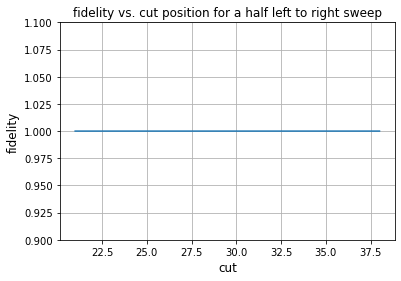

In [9]:
plt.plot(np.arange(system_size//2 + 1,len(fidelity) + system_size//2 + 1),fidelity)
plt.grid('on')
plt.xlabel('cut', fontsize = 12)
plt.ylabel('fidelity', fontsize = 12)
plt.title('fidelity vs. cut position for a half left to right sweep', fontsize = 12)
plt.ylim(0.9, 1.1)

### Right-to-Left Half Sweep

In [10]:
Sz_R_last = Sz_list_R[n_iter]
Sp_R_last = Sp_list_R[n_iter]
Sm_R_last = Sm_list_R[n_iter]

block_H_Right = block_H_list_R[n_iter]
block_Id_Right = block_Id_list_R[n_iter]

Psi_last = np.load('Psi_infinite.npy')

In [11]:
system_size = 2*n_iter + 2

###############################
#   Begin main iterations
###############################

truncation_error = np.zeros(n_iter_l)
energy_per_bond = np.zeros(n_iter_l)
fidelity = np.zeros(n_iter_l)

start = timeit.default_timer()
for l in range(n_iter_l):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Left block's operators (Shrink)
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Sz_L_last = Sz_list_L[n_iter - (l+2)]
    Sp_L_last = Sp_list_L[n_iter - (l+2)]
    Sm_L_last = Sm_list_L[n_iter - (l+2)]
    
    block_H_Left = block_H_list_L[n_iter - (l+2)]
    block_Id_Left = block_Id_list_L[n_iter - (l+2)]
    
    TL_inf = TL_list[n_iter - (l+2)]
    TL_dag_inf = TL_dag_list[n_iter - (l+2)]
    
    Permute_Left = Permute_L[n_iter - (l+2)]
    Permute_dag_Left = Permute_dag_L[n_iter - (l+2)]
    
    block_H_Left = kron(block_H_Left, I) + kron(Sz_L_last, Sz) + 0.5 * (kron(Sp_L_last, Sm) + kron(Sm_L_last, Sp))\
    -h*kron(block_Id_Left, Sz)
    
    Sz_L_last = kron(block_Id_Left,Sz)
    Sp_L_last = kron(block_Id_Left,Sp)
    Sm_L_last = kron(block_Id_Left,Sm)
    block_Id_Left = kron(block_Id_Left,I)

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Adding site to right block
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    block_H_Right = kron(block_H_Right, I) + J*(kron(Sz_R_last, Sz) + 0.5 * (kron(Sp_R_last, Sm) + kron(Sm_R_last, Sp)))\
    -h*kron(block_Id_Right, Sz)
    
    Sz_R_last = kron(block_Id_Right,Sz)
    Sp_R_last = kron(block_Id_Right,Sp)
    Sm_R_last = kron(block_Id_Right,Sm)
    block_Id_Right = kron(block_Id_Right,I)
    
    ######################################################################
    #   Lz operator for right block and building the permutation matrix
    ######################################################################
    # Sz{i}:
    for x in range(len(Z_R)):
        Z_R[x] = kron(Z_R[x],I)
        
    Z_R.append(Sz_R_last)
    
    dim_n = np.size(Z_R[0],axis=1)
    
    #Lz operator for right block:
    Lz_Right = csr((dim_n,dim_n))  
    
    for i in range(len(Z_R)):
        Lz_Right += Z_R[i]
    
     # sorting Lz's diag in order to find the permutation matrix
    Lz_R_diag = np.diag(Lz_Right.todense())
    sort_R  = np.argsort(Lz_R_diag) 
    
    UR = lil((dim_n, dim_n)) #Transformation matrix for left block
    for i in range(dim_n):
        UR[sort_R[i], i] = 1
    UR_dag = lil.transpose(UR)
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Permutation for left and right block operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Right %%%%%%%%%%%
    block_H_Right = UR_dag*block_H_Right*UR
    
    Sz_R_last = UR_dag*Sz_R_last*UR
    Sm_R_last = UR_dag*Sm_R_last*UR
    Sp_R_last = UR_dag*Sp_R_last*UR
    
    block_Id_Right = UR_dag*block_Id_Right*UR

    
    #%%%%%%%%%% Left %%%%%%%%%%%
    block_H_Left = Permute_dag_Left*block_H_Left*Permute_Left
    
    Sz_L_last = Permute_dag_Left*Sz_L_last*Permute_Left
    Sm_L_last = Permute_dag_Left*Sm_L_last*Permute_Left
    Sp_L_last = Permute_dag_Left*Sp_L_last*Permute_Left
    
    block_Id_Left = Permute_dag_Left*block_Id_Left*Permute_Left
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    OL = [];                             OR = [];
    OL.append(block_H_Left);             OR.append(block_Id_Right);
    OL.append(block_Id_Left);            OR.append(block_H_Right);
    OL.append(Sz_L_last);                OR.append(Sz_R_last);
    OL.append(0.5*Sp_L_last);            OR.append(Sp_R_last);
    OL.append(0.5*Sm_L_last);            OR.append(Sm_R_last);
    
    H_superblock = kron(block_H_Left,block_Id_Right) + kron(block_Id_Left,block_H_Right)+ kron(Sz_L_last,Sz_R_last)\
    + 0.5 * (kron(Sp_L_last,Sm_R_last) + kron(Sm_L_last,Sp_R_last))

    H_superblock = 0.5 * (H_superblock + H_superblock.T); 
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Diagonalizing the Hamiltonian with Lancsoz algorithm
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    max_iter = 100
    
    Dim_L = np.size(OL[0], axis = 1) #left operators dimension
    Dim_R = np.size(OR[0], axis = 1) #right operators dimension

    Dim_tot = Dim_L*Dim_R #superblock Hamiltonian dimension
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Wave function transformation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Psi_init = np.copy(Psi_last)
    Rho_R =  np.matmul(Psi_init.T,Psi_init)
    D_R, V_R = LA.eigh(Rho_R)
    sorted_index_R = np.argsort(D_R)[::-1]   # sort eigenvalues descending
    V_R = V_R[:, sorted_index_R]            # sort eigenvectors the same way
    n_r = min(len(D_R), n_kept_states)
    T_R = csr(V_R[:, :n_r])
    n_l = np.size(TL_inf, axis = 1)

    Psi_right = Psi_init * T_R
    Psi_permuted = Permute_L[n_iter - (l+1)] * Psi_right

    Psi_permuted =  np.reshape(Psi_permuted,(n_l,2,n_r))
    
    Psi_permuted = np.transpose(Psi_permuted, (0,2,1))
    
    Psi_new =  np.reshape(Psi_permuted,(n_l,2*n_r))
    
    Psi_new = Psi_new * UR
    
    Psi_left =  TL_inf * Psi_new
    
    Psi_left = np.reshape(Psi_left,(Dim_tot,-1))
    
    Psi_vec = Psi_left/np.linalg.norm(Psi_left)
    v0 = Psi_vec
    
    #Energy,Psi = Lanczos(OL,OR,1,max_iter,v0) #diagonalization with lancsoz
    Energy,Psi = eigsh(H_superblock, k = 1,v0 = v0, which = 'SA') #diagonalization with lancsoz
    

    fidelity[l] = (np.dot(v0.T, Psi))**2
    
    energy = Energy[0]
    energy_per_bond[l] = energy/System_Size
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_Left,axis=1)
    dim_block_right = np.size(block_H_Right,axis=1)
    
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    Psi_last = np.copy(Psi_matrix)
    
    Rho_L = np.matmul(Psi_matrix,Psi_matrix.T) #reduced density matrix
    Rho_R = np.matmul(Psi_matrix.T,Psi_matrix) #reduced density matrix
    
    n_kept_temp_L = min(dim_block_left, n_kept_states)
    n_kept_temp_R = min(dim_block_right, n_kept_states)
    
    D_L, V_L = LA.eigh(Rho_L)
    sort_ind_L = np.argsort(D_L)[::-1] #sorting eigen values in descending order
    D_L = D_L[sort_ind_L]
    V_L = V_L[:, sort_ind_L] #corresponding eigen vectors
    
    D_R, V_R = LA.eigh(Rho_R)
    sort_ind_R = np.argsort(D_R)[::-1] #sorting eigen values in descending order
    D_R = D_R[sort_ind_R]
    V_R = V_R[:, sort_ind_R] #corresponding eigen vectors
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    Trunc_L = csr(V_L[:, :n_kept_temp_L]) #Left block operators truncation
    Trunc_L_dag = csr.transpose(Trunc_L)
    
    Trunc_R = csr(V_R[:, :n_kept_temp_R])
    Trunc_R_dag = csr.transpose(Trunc_R) #Right block operators truncation
    
    #print(np.shape(Trunc_R_dag))

    
    truncation_error[l] = 1 - np.sum(D_L[:n_kept_temp_L])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f\t ' %(l, energy, energy_per_bond[l], truncation_error[l]))
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Transform the block operators into the truncated basis
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%% Right %%%%%%%%%%%    
    block_H_Right  = Trunc_R_dag*block_H_Right*Trunc_R
    block_Id_Right = Trunc_R_dag*block_Id_Right*Trunc_R
    
    Sz_R_last  = Trunc_R_dag*Sz_R_last*Trunc_R
    Sm_R_last = Trunc_R_dag*Sm_R_last*Trunc_R
    Sp_R_last = Trunc_R_dag*Sp_R_last*Trunc_R
    
    #%%%%%%%%% Truncation for Sz{i} %%%%%%%%
    T_R = UR * Trunc_R; T_R_dag = csr.transpose(T_R)
    
    for i in range(len(Z_R)): 
        Z_R[i] = T_R_dag*Z_R[i]*T_R
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Saving Operator for finite DMRG
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    #%%%%%%%%%% Right %%%%%%%%%%% 
    Sz_list_R.append(Sz_R_last)
    Sm_list_R.append(Sm_R_last)
    Sp_list_R.append(Sp_R_last)

    block_H_list_R.append(block_H_Right)
    block_Id_list_R.append(block_Id_Right)

    
        
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 0	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 1	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 2	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 3	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 4	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 5	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 6	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 7	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 8	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 9	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 10	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 11	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 12	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 13	 total_En: -17.5414	 En_per_bound: -0.4385	 trunErr: 0.0000	 
iter: 14	 total_

In [12]:
fidelity

array([0.99967594, 0.99999965, 0.99999936, 0.99999962, 0.99999911,
       0.9999996 , 0.99999895, 0.99999963, 0.99999901, 0.99999971,
       0.99999932, 0.99999983, 0.99999976, 0.99999995, 1.        ,
       1.        , 1.        , 1.        ])

Text(0.5, 1.0, 'fidelity vs. cut position for a half right to left sweep')

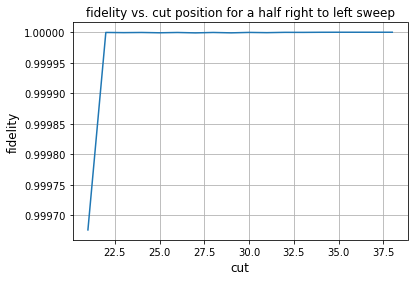

In [13]:
plt.plot(np.arange(system_size//2 + 1,len(fidelity) + system_size//2 + 1),fidelity)
plt.grid('on')
plt.xlabel('cut', fontsize = 12)
plt.ylabel('fidelity', fontsize = 12)
plt.title('fidelity vs. cut position for a half right to left sweep', fontsize = 12)
#plt.ylim(0.9, 1.1)